# Periodic Model Violations: Asymmetric Oscillations

In this set of simulations, we will test FOOOF's performance across power spectra that violate some of the assumptions of the FOOOF model, in particular regarding the periodic components.

In this example, we will explore the case of asymmetric oscillations, in the time domain. 

### Notes on asymmetric oscillations

For these simulations, we will simulate time series, from which we can calculate power spectra, and then 

Here we are simulating asymmetric oscillations in the time domain, which create harmonic peaks in the frequency domain. Note that non-sinuisoidal or asymmetric oscillations in the time domain do not themselves produce asymmetric peaks in the frequency domain. 

### Conclusions

As we will see through these simulations, FOOOF is able to deal quite well with these oscillations, basically by fitting peaks to the harmonics. This leads to a 'good' model fit, both in terms of appropriately capturing the variance of the data, and in terms of isolating peaks in order to measure the aperiodic component.

However, this property of harmonics exhibiting as peaks does demonstrate that there is not a direct mapping between peaks in the frequency domain, as detected by FOOOF, and rhythmic activity in the time series, at those particular frequencies. As is true in many signal processing approaches, harmonics mean that power at a particular frequency cannot automatically be assumed to represent activity specific to that frequency. This should always be considered when interpreting peaks as detected by FOOOF, and care should be taken to ascertain if and when some of them may be due to harmonics.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from neurodsp import sim, spectral, plts
from neurodsp.utils import create_times

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.plts import plot_spectrum
from fooof.data import SimParams
from fooof.sim import param_sampler

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [3]:
# Set random seed
import random
random.seed(333)

In [4]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [5]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = True

In [6]:
# Set the number of sims to run (per conditions)
N_SIMS = 1000

# Set the range to fit with FOOOF
fooof_fit_range = [2, 50]

# Define the conditions
comp_vars = [[0, 1], [0.25, 1], [0.5, 1], [0.75, 1], [1, 1]]
cond_labels = [val[0] for val in comp_vars]
n_comp_vars = len(comp_vars)

# Set the time series settings
RD_SYM = 0.3
F_RANGE = (1, None)

# Convert exponent definitions for NeuroDSP format (uses negatives)
EXP_OPTS = [-val for val in EXP_OPTS]

## Asymetric Oscillations in the Time Domain

In [7]:
# Simulation settings
sims = {'sim_oscillation' : {'freq' : 10, 'cycle' : 'asine', 'rdsym' : 0.3},
        'sim_powerlaw' : {'exponent' : -1.5, 'f_range' : (1, None)}}
ex_comp_var = [0.5, 1]

In [8]:
# Simulate the time series
sig = sim.sim_combined(N_SECONDS, FS, sims, ex_comp_var)

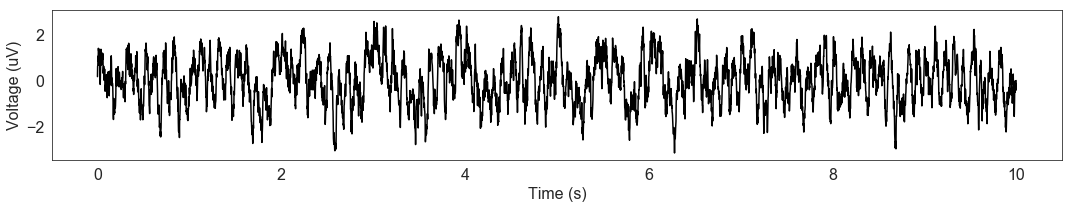

In [9]:
# Check out our simulated time series
plts.plot_time_series(create_times(N_SECONDS, FS), sig)

In [10]:
# Compute the power spectrum
freqs, pows = spectral.compute_spectrum(sig, FS)

# Collect the size of the frequency axis, for later
n_freqs = len(freqs)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.5431, 1.4267                                          
                                                                                                  
                                       2 peaks were found:                                        
          

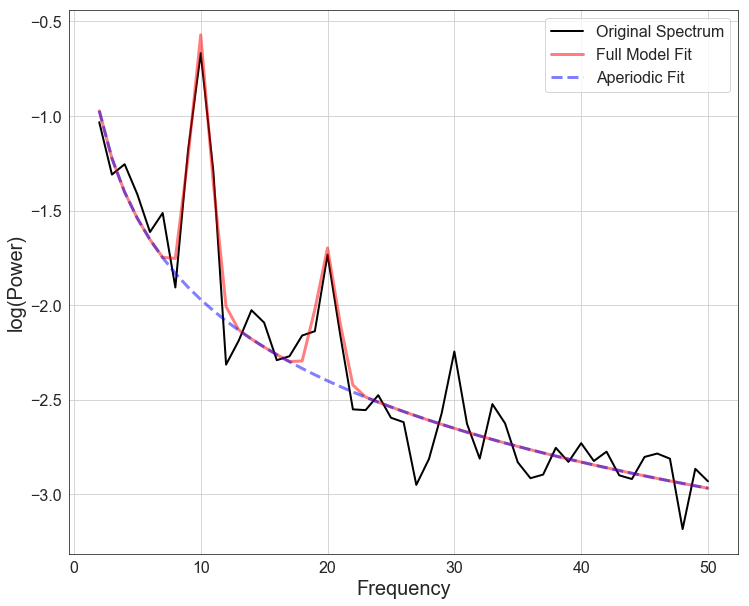

In [11]:
# Fit a FOOOF model
fm = FOOOF(min_peak_height=0.5, verbose=False)
fm.report(freqs, pows, fooof_fit_range)

### Simulate Data

In [12]:
# Generate or load power spectra
data_name = 'mvpe_aosc_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_comp_vars, N_SIMS, n_freqs])
    sim_params = [deepcopy([None] * N_SIMS) for ii in range(n_comp_vars)]
    
    # Initialize generators to sample parameters from
    exp_sampler = param_sampler(EXP_OPTS, EXP_PROBS)
    cf_sampler = param_sampler(CF_OPTS, CF_PROBS)

    # Generate simulated power spectra
    for n_ind, comp_var in enumerate(comp_vars):
        
        for s_ind in range(N_SIMS):
        
            # Get the current values to use for the exponent and peak frequency
            exp_val = next(exp_sampler)
            cf_val = next(cf_sampler)

            # Collect together simulated parameters
            sim_params[n_ind][s_ind] = SimParams([None, exp_val],
                                                 [cf_val, None, None],
                                                 None)

            # Simulation settings for time series
            sims = {'sim_oscillation' : {'freq' : cf_val,
                                         'cycle' : 'asine',
                                         'rdsym' : RD_SYM},
                    'sim_powerlaw' : {'exponent' : exp_val,
                                      'f_range' : F_RANGE}}

            # Simulate the time series
            sig = sim.sim_combined(N_SECONDS, FS, sims, comp_var)

            # Compute the power spectrum
            _, psds[n_ind, s_ind, :] = spectral.compute_spectrum(sig, FS)    
            
    # Save out generated simulated data & parameter definitions
    save_sim_data(data_name, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name)           
        
# Check shape
print('n_comp_vars, n_spectra, n_freqs : ', psds.shape)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


n_comp_vars, n_spectra, n_freqs :  (5, 1000, 251)


In [13]:
# Extract ground truth values of the simulations
osc_truths, ap_truths = get_ground_truth(sim_params)

# Extract parameters of interest, and force arrays back to float
cf_truths = np.array(osc_truths[:, :, 0], dtype=float)
exp_truths = np.array(ap_truths[:, :, 1], dtype=float) * -1

### Fit Power Spectra with FOOOF

In [14]:
# Initialize FOOOFGroup to fit with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.5,
                aperiodic_mode='fixed', verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.5                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [15]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds, fooof_fit_range)

### Extract FOOOF fit Data

In [16]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

cf_fits = np.array(peak_fits[:, :, 0], dtype=float)
exp_fits = np.array(ap_fits[:, :, 1], dtype=float)

In [17]:
# Calculate error
exp_errors = calc_errors(exp_truths, exp_fits)
cf_errors = calc_errors(cf_truths, cf_fits)

# Special case: set case in which there was no peak to all be nan
#   There are so few detected peaks in this case,
#   that summary statistics are basically meaningless
cf_errors[0, :] = np.nan

In [18]:
# Count how many peaks were detected across conditions
n_peak_counter = count_peak_conditions(n_fit_peaks, cond_labels)

### Check Average Errors & Stats

In [19]:
# Check overall fit quality
temp = r2_fits[~np.isnan(r2_fits)].flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.3009 	0.9921
Median  R^2: 	0.9377


In [20]:
# Collect data together
datas = {
    'EXP' : exp_errors,
    'CF' : cf_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [21]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

EXP
	 [0.05325136 0.05790575 0.0579806  0.05659438 0.05888961]
CF
	 [       nan 0.15150181 0.13018768 0.10622947 0.1027558 ]
ERR
	 [0.10091777 0.10235264 0.10217474 0.10292525 0.10376972]
R^2
	 [0.91230169 0.92758372 0.93462174 0.94356837 0.94795855]


/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


### Create Plots

#### Periodic Components

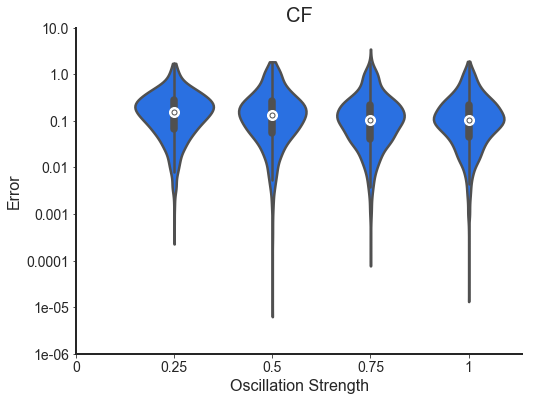

In [22]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(cf_errors, 'CF', x_axis='osc_strength',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='mvpe_cf')

##### Number of fit Peaks

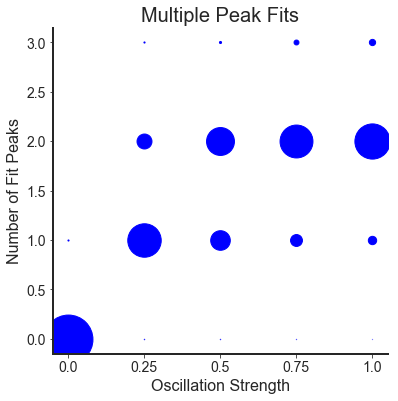

In [23]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_peaks_bubbles(n_peak_counter, ms_val=10, x_label='osc_str',
                     save_fig=SAVE_FIG, save_name='harmonics')

##### Harmonic Structure of Peaks

In the above, we can see that we are fitting more peaks than we might expect, given that there is one actual oscillation in each signal. This is because these asymmetric oscillations create harmonics in the power spectra, which as also fit as peaks. 

To explore this, we can check the 'harmonic structure' of the detected peaks. Harmonics should have a precise relationship between the detected frequencies. In the next analysis, we can extract all peaks, and label the lowest detected peak as `f0`. Then we can examine if the other detected peaks have a harmonic relationship to this re-labelled peak. 

The plots below are labelled with `f1` reflecting `2 x f0`, and `f2` reflecting `3 x f0`, etc. In this way, we can see if detected peaks cluster around `f1` and `f2`. If so, this is evidence of harmonic structure in the data. Note that the `f0` peaks themselves are not plotted. 

In [24]:
# Get the harmonic mapping of all the peak center frequencies
harmonic_peaks = [harmonic_mapping(fg) for fg in fgs]

In [25]:
# Collapse across all oscillation strengths
all_harm_peaks = [it for lst in harmonic_peaks for it in lst]

In [26]:
# Grab the harmonic mapping of peaks, separately for cases with 2 and 3 detected peaks
h2s = np.array([val[1] for val in all_harm_peaks if len(val) == 2])
h3s = np.array([val[1:] for val in all_harm_peaks if len(val) == 3])

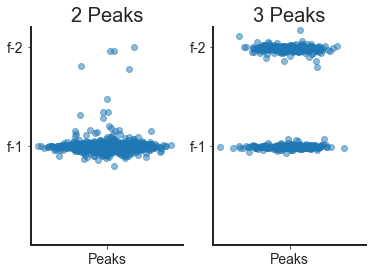

In [27]:
# Plot the harmonic structure of peaks
fig, axes = plt.subplots(1, 2, figsize=[6, 4])
plot_harmonics(h2s, title='2 Peaks', ax=axes[0])
plot_harmonics(h3s, title='3 Peaks', ax=axes[1])

#### Aperiodic Components

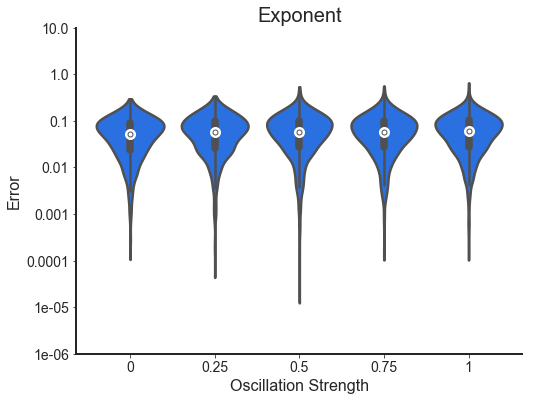

In [28]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(exp_errors, 'Exponent', x_axis='osc_strength',
                   plt_log=True, y_label=None,
                   save_fig=SAVE_FIG, save_name='XXXX')

### Example FOOOF Fits

SimParams(aperiodic_params=[None, -2], gaussian_params=[11, None, None], nlv=None)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.1065, 1.8791                                          
                                                                                                  
                          

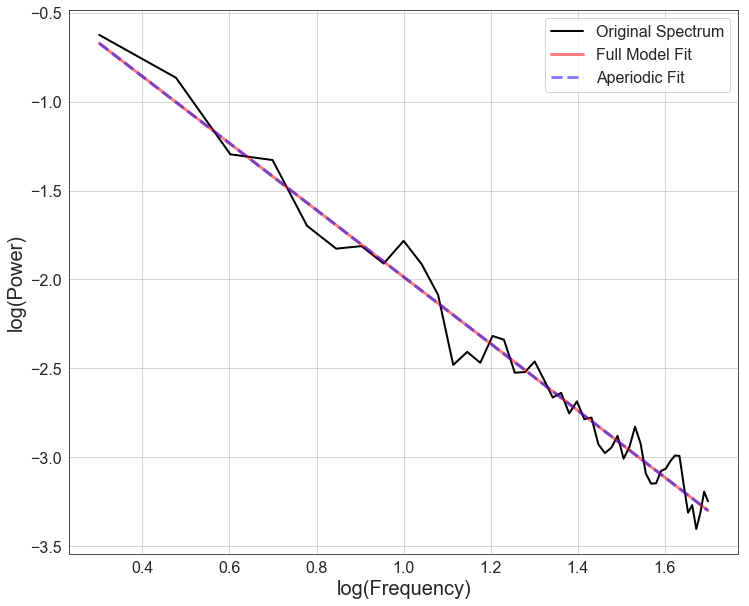

In [29]:
# Grab example cases - low noise
ind = 15
fm_nlv1 = fgs[0].get_fooof(ind, True)
print(sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(plt_log=True, save_fig=SAVE_FIG,
             file_path=FIGS_PATH, file_name='MVPE1-OSCSTR1')

SimParams(aperiodic_params=[None, -2], gaussian_params=[6, None, None], nlv=None)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.2134, 2.0056                                          
                                                                                                  
                           

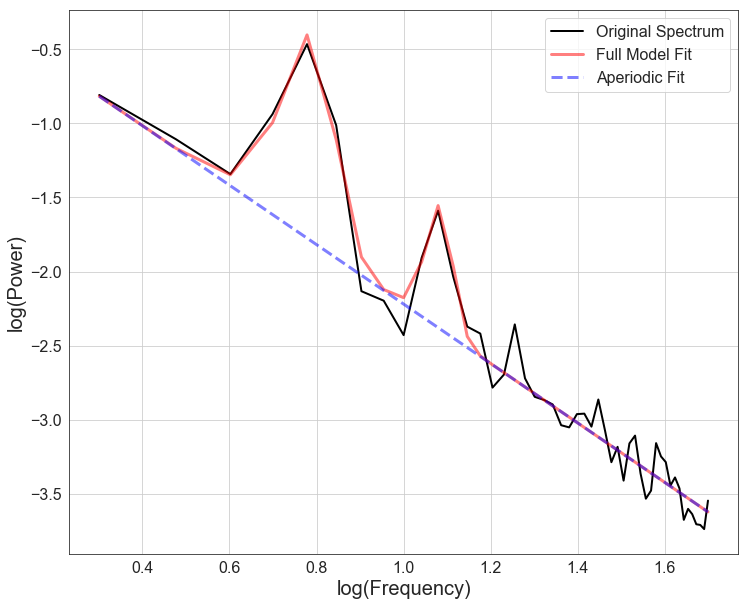

In [30]:
# Grab example cases - low noise
ind = 10
fm_nlv1 = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm_nlv1.print_results()
fm_nlv1.plot(plt_log=True, save_fig=SAVE_FIG,
             file_path=FIGS_PATH, file_name='MVPE1-OSCSTR5')